In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import MinMaxScaler

GOLD_PARQUET_PATH = '/usr/datalake/silver/igra/liftedindex_lr/gph20s10k_li.parquet'
epochs = 64
grid_count = 40
max_neurons = 200
learning_rate = 0.001

In [2]:
def load_dataset():
    X = pd.read_parquet(GOLD_PARQUET_PATH)

    # Remove irrelevant data
    X = X.drop(['id', 'effective_date', 'hour', 'li'], axis=1)
    
    # Scale the X dataset
    ss = MinMaxScaler() 
    X = ss.fit_transform(X)

    return X

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_features: int):
        super().__init__()
        self.n_features = n_features
          
    def scenario_2d(self, l2: int, l1: int):
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_features, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l1)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, self.n_features)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [4]:
x_train = load_dataset()
n_features = len(x_train[0])
print (f"Training size: {x_train.size:,}")
print (f"Feature count: {n_features}")

x_train = torch.from_numpy(x_train).float().cuda()

Training size: 45,598,080
Feature count: 127


In [5]:
def train(model, loss_fn, optimizer, inputs) -> float:
    optimizer.zero_grad()

    # Compute prediction error
    logits = model(inputs)
    loss = loss_fn(inputs, logits)

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    return float(loss.item())

def grid_search_2d():
    output = []

    coly = np.linspace(5, max_neurons, grid_count, dtype=int)
    loss_function = torch.nn.MSELoss().cuda()
    X, Y = np.meshgrid(coly, coly)
    cache_count = 0

    for l1, l2 in [(x, y) for y in coly for x in coly]:
        print(f"Layers: ({l1}, {l2})", end="")
        
        if l1 > l2:
            output.append(0)
            print(", illogical")
            continue
    
        if (l1 + l2) > max_neurons:
            output.append(0)
            print(", too big")
            continue

        if l1 > 50:
            output.append(0)
            print(", too loose")
            continue

        model = AutoEncoder(n_features)
        model.scenario_2d(l2, l1)
        model.cuda()

        optimizer = torch.optim.Adam(model.parameters())

        for _ in range(epochs):
            cost = train(model, loss_function, optimizer, x_train)

        print(f", {cost:.5f}")
        output.append(cost)

        del optimizer
        del model
        cache_count += 1

        if cache_count % 5 == 0:
            torch.cuda.empty_cache()
    
    return X, Y, output

X, Y, output = grid_search_2d()

Layers: (5, 5), 0.25432
Layers: (10, 5), illogical
Layers: (15, 5), illogical
Layers: (20, 5), illogical
Layers: (25, 5), illogical
Layers: (30, 5), illogical
Layers: (35, 5), illogical
Layers: (40, 5), illogical
Layers: (45, 5), illogical
Layers: (50, 5), illogical
Layers: (55, 5), illogical
Layers: (60, 5), illogical
Layers: (65, 5), illogical
Layers: (70, 5), illogical
Layers: (75, 5), illogical
Layers: (80, 5), illogical
Layers: (85, 5), illogical
Layers: (90, 5), illogical
Layers: (95, 5), illogical
Layers: (100, 5), illogical
Layers: (105, 5), illogical
Layers: (110, 5), illogical
Layers: (115, 5), illogical
Layers: (120, 5), illogical
Layers: (125, 5), illogical
Layers: (130, 5), illogical
Layers: (135, 5), illogical
Layers: (140, 5), illogical
Layers: (145, 5), illogical
Layers: (150, 5), illogical
Layers: (155, 5), illogical
Layers: (160, 5), illogical
Layers: (165, 5), illogical
Layers: (170, 5), illogical
Layers: (175, 5), illogical
Layers: (180, 5), illogical
Layers: (185, 

C:\Users\oliev\AppData\Local\Temp\ipykernel_15076\1329582521.py:2: RuntimeWarning: divide by zero encountered in log
  Z = np.log(Z)


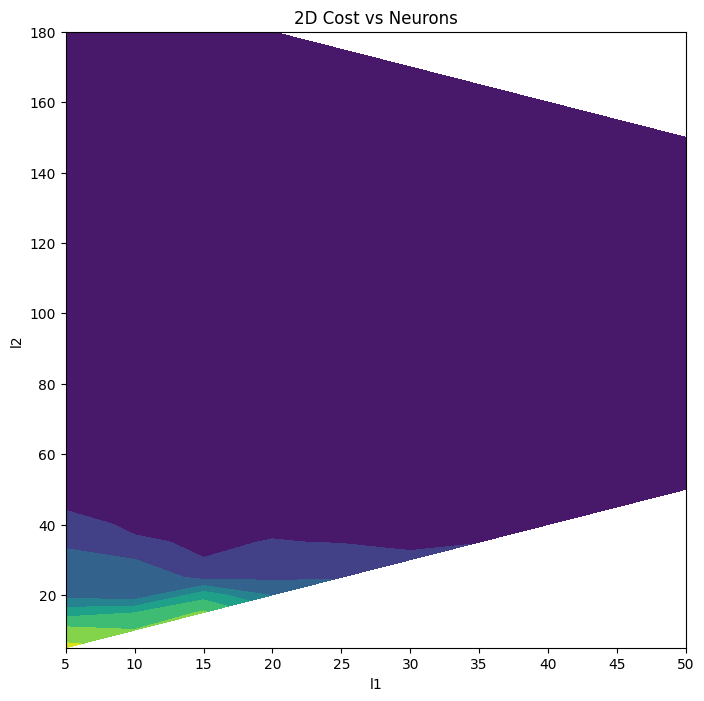

In [7]:
Z = np.reshape(output, (grid_count, grid_count))
Z = np.log(Z)
fig, ax = plt.subplots(figsize=(8, 8))

ax.title.set_text('2D Cost vs Neurons')
ax.contourf(X, Y, Z)
ax.set_xlabel('l1')
ax.set_ylabel('l2')
ax.set_xlim(5, 50)
ax.set_ylim(5, 180)
plt.savefig("ReLU_StandardScaler_Adam_MSE.png")
plt.show()